In [50]:
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="c6-championstweet")):
    res = es.indices.create(index="c6-championstweet")  
    pprint(res)

In [2]:
import json
import os
files = os.listdir("Dataset")
pprint(len(files))

354586


In [8]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('Dataset/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            #pprint(tweet)
            timestamp=int(tweet["timestamp_ms"])
            
            simple_tweet = {"date":tweet["created_at"], \
                            "timestamp":timestamp, \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="c6-championstweet", doc_type="_doc")
        tweets=[]


### 1. En un histograma o en un line plot, visualizar el número de tweets conteniendo la palabra “goal”, cada minuto y cada 10 minutos. (BONUS: gestionar las variantes “goaaal”, “goooaallll”, etc. utilizando expresiones regulares).

In [51]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [194]:
res = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "text":"goal"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "1m"
                           }
                       }
                   }
               }) 
df_goalByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_goalByMinutes = df_goalByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_goalByMinutes_filtered= df_goalByMinutes.drop(df_goalByMinutes[df_goalByMinutes.timestamp < 1527357600000 ].index)



In [198]:
res2 = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "text":"goal"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "10m"
                           }
                       }
                   }
               }) 
df_goal2ByMinutes = pd.DataFrame(res2['aggregations']['tweets_over_time']['buckets'])
df_goal2ByMinutes = df_goal2ByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets2'})
df_goal2ByMinutes_filtered = df_goal2ByMinutes.drop(df_goal2ByMinutes[df_goal2ByMinutes.timestamp < 1527357600000 ].index)

In [199]:
def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_goalByMinutes_filtered['timestamp']=df_goalByMinutes_filtered['timestamp'].apply(timestamp2date)
df_goal2ByMinutes_filtered['timestamp']=df_goal2ByMinutes_filtered['timestamp'].apply(timestamp2date)

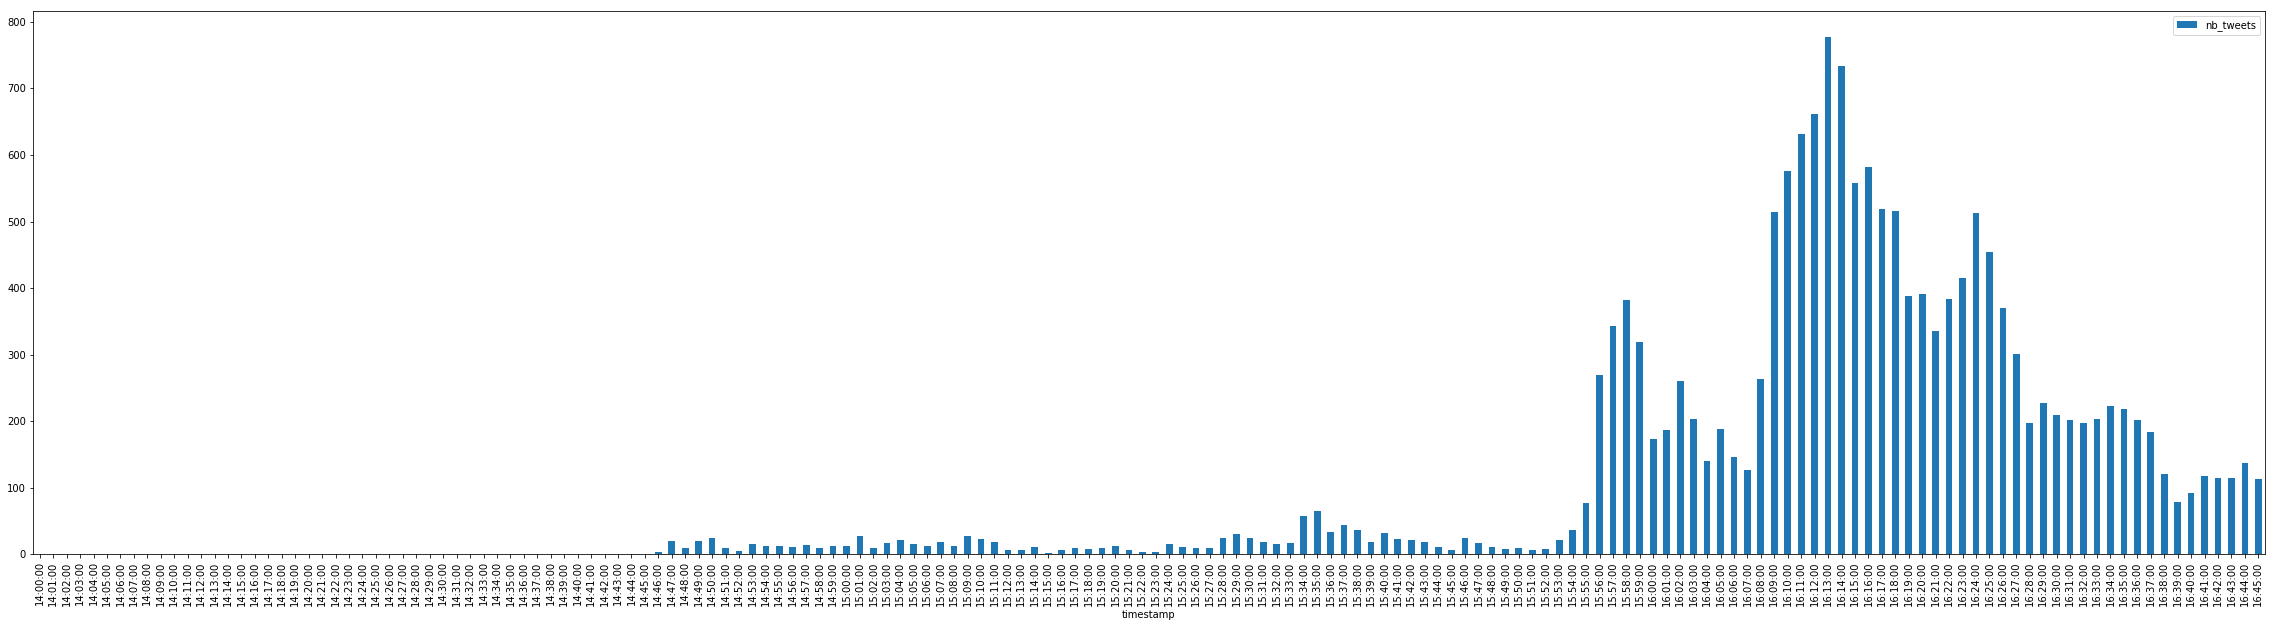

In [200]:
%matplotlib inline

df_goalByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

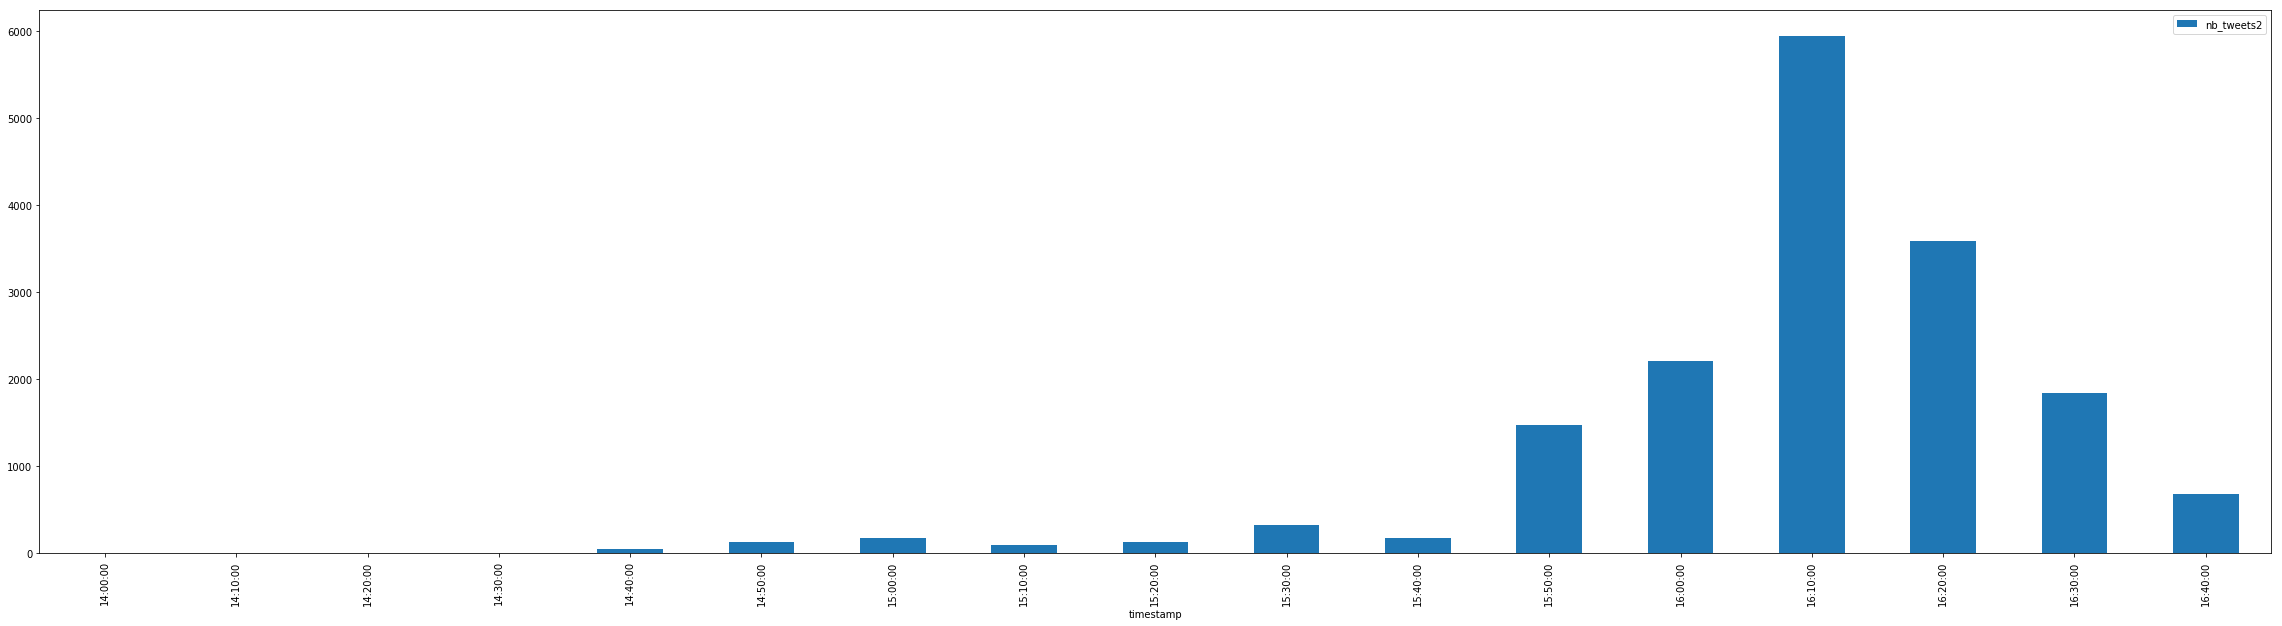

In [201]:
%matplotlib inline

df_goal2ByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

### 2. En un histograma o en un line plot, visualizar dos series de datos: 
### a) el número de tweets que hablan de ‘liverpool’ por cada minuto,
### b) el número de tweets que hablan de ‘madrid’ por cada minuto.
         ¿A qué minuto se habla más de Madrid?

In [202]:
# el número de tweets que hablan de ‘liverpool’ por cada minuto
res3 = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "text":"liverpool"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "1m"
                           }
                       }
                   }
               }) 
df_liverpoolByMinutes = pd.DataFrame(res3['aggregations']['tweets_over_time']['buckets'])
df_liverpoolByMinutes = df_liverpoolByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweetsliv'})
df_liverpoolByMinutes_filtered= df_liverpoolByMinutes.drop(df_liverpoolByMinutes[df_liverpoolByMinutes.timestamp < 1527357600000 ].index)
df_liverpoolByMinutes_filtered['timestamp']=df_liverpoolByMinutes_filtered['timestamp'].apply(timestamp2date)

In [203]:
# el número de tweets que hablan de ‘madrid’ por cada minuto
res4 = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "text":"madrid"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "1m"
                           }
                       }
                   }
               }) 
df_madridByMinutes = pd.DataFrame(res4['aggregations']['tweets_over_time']['buckets'])
df_madridByMinutes = df_madridByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweetsmad'})
df_madridByMinutes_filtered = df_madridByMinutes.drop(df_madridByMinutes[df_madridByMinutes.timestamp < 1527357600000 ].index)
df_madridByMinutes_filtered['timestamp']=df_madridByMinutes_filtered['timestamp'].apply(timestamp2date)

In [204]:
df_liv_mad=pd.concat([df_madridByMinutes_filtered, df_liverpoolByMinutes_filtered['nb_tweetsliv']], axis=1)

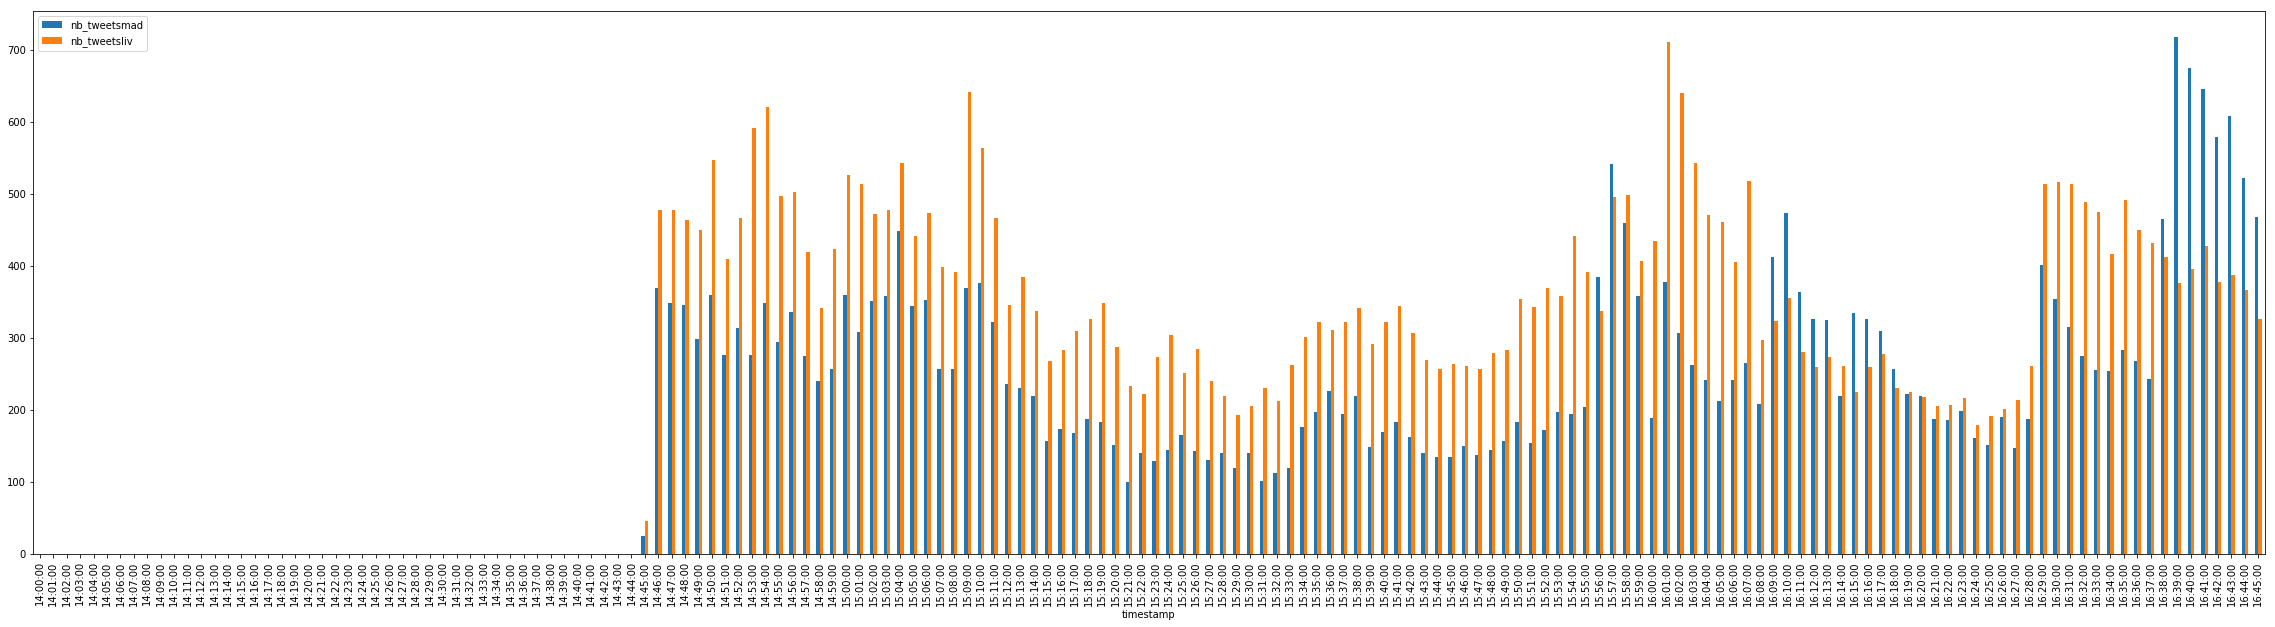

In [205]:
%matplotlib inline

df_liv_mad.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

A las 16:39 se habla más de Madrid

### 3. En un dataframe, mostrar el número de tweets según el país indicado en el campo ‘location’. ¿Desde cuáles países se enviaron los tweets? (BONUS: mostrar los resultados en una mapa).

In [184]:
res5 = es.search(index="c6-championstweet",
               body=
{
    "aggs" : {
        "distinct_location" : {
            "terms" : {
              "field" : "location.keyword",
                "size" : 354000
            }
        }
    }
})
#res5

In [185]:
df_location = pd.DataFrame(res5['aggregations']['distinct_location']['buckets'])
df_location = df_location.rename(columns={'key': 'location', 'doc_count': 'n_tweets'})
df_location[:10]

,n_tweets,location
0,3494,"Lagos, Nigeria"
1,2540,Nigeria
2,1929,"London, England"
3,1750,"Nairobi, Kenya"
4,1661,South Africa
5,1423,"Johannesburg, South Africa"
6,1189,London
7,1018,Brasil
8,1001,United Kingdom
9,941,"Rio de Janeiro, Brasil"



### 4. En un histograma o en un line plot, visualizar dos series de datos:
### a) el número de tweets enviado desde Inglaterra, por cada minuto.
### b) el número de tweets enviado desde España, por cada minuto.


In [237]:
# el número de tweets enviado desde Inglaterra, por cada minuto
res6 = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "location":"england"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "1m"
                           }
                       }
                   }
               }) 
df_inglaterraByMinutes = pd.DataFrame(res6['aggregations']['tweets_over_time']['buckets'])
df_inglaterraByMinutes = df_inglaterraByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweetsingl'})
df_inglaterraByMinutes_filtered= df_inglaterraByMinutes.drop(df_inglaterraByMinutes[df_inglaterraByMinutes.timestamp < 1527357600000 ].index)
df_inglaterraByMinutes_filtered['timestamp']=df_inglaterraByMinutes_filtered['timestamp'].apply(timestamp2date)

In [238]:
# el número de tweets enviado desde España, por cada minuto
res7 = es.search(index="c6-championstweet",
               body={
                   "query": {
                       "term":{
                           "location":"spain"
                       }
                   },
                   "aggs" : {
                       "tweets_over_time":{
                           "date_histogram":{
                               "field" :"timestamp",
                               "interval" : "1m"
                           }
                       }
                   }
               }) 
df_espanaByMinutes = pd.DataFrame(res7['aggregations']['tweets_over_time']['buckets'])
df_espanaByMinutes = df_espanaByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweetsesp'})
df_espanaByMinutes_filtered= df_espanaByMinutes.drop(df_espanaByMinutes[df_espanaByMinutes.timestamp < 1527357600000 ].index)
df_espanaByMinutes_filtered['timestamp']=df_espanaByMinutes_filtered['timestamp'].apply(timestamp2date)

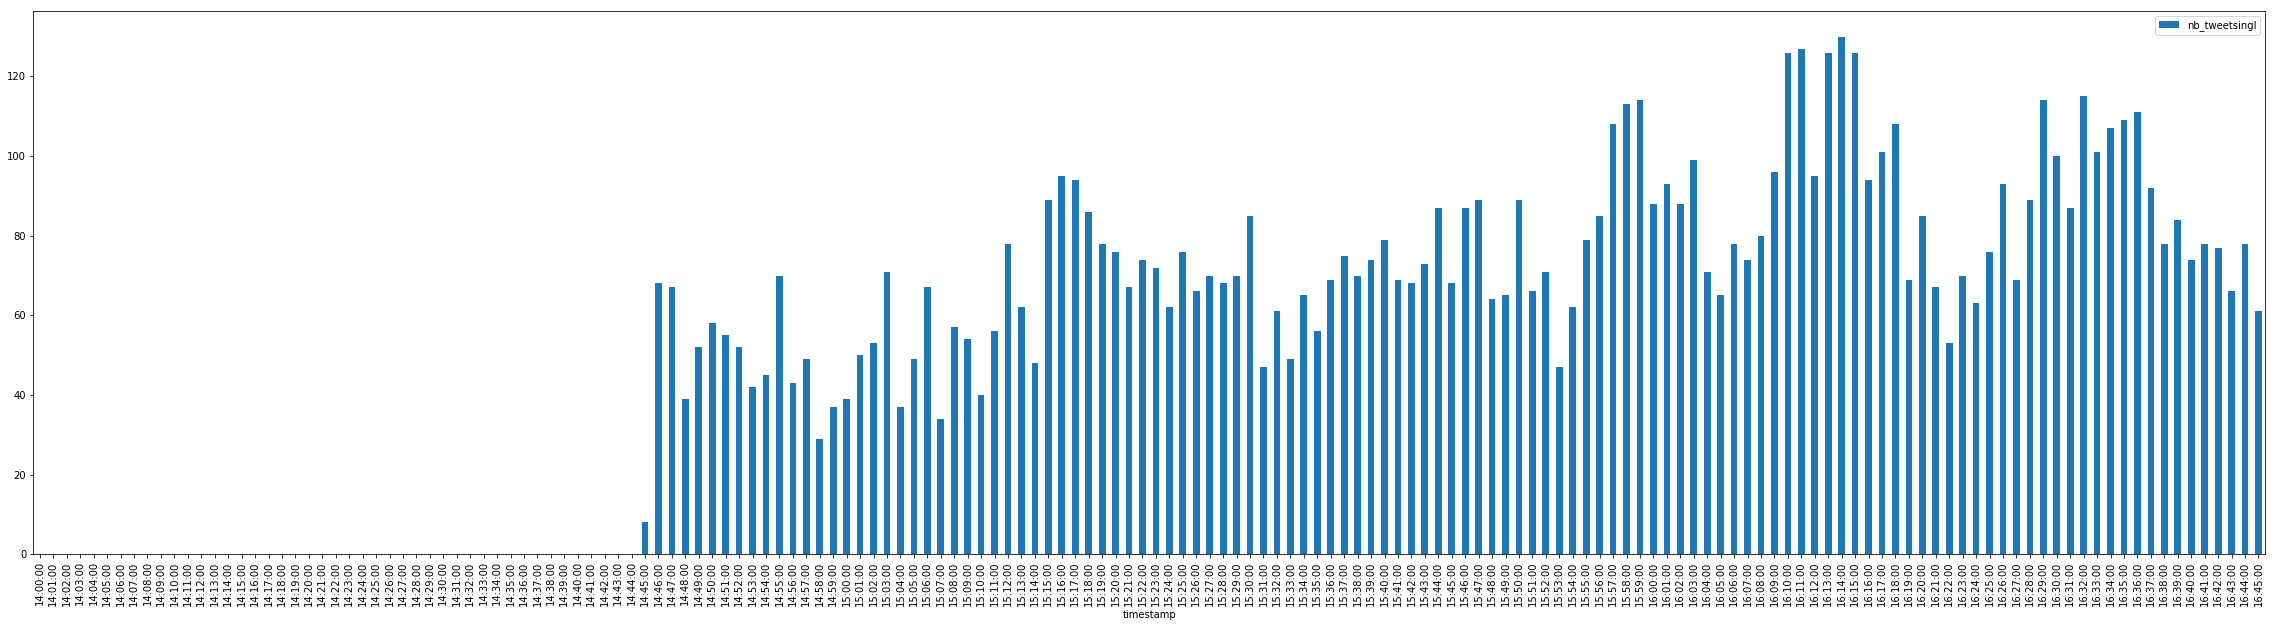

In [239]:
%matplotlib inline

df_inglaterraByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

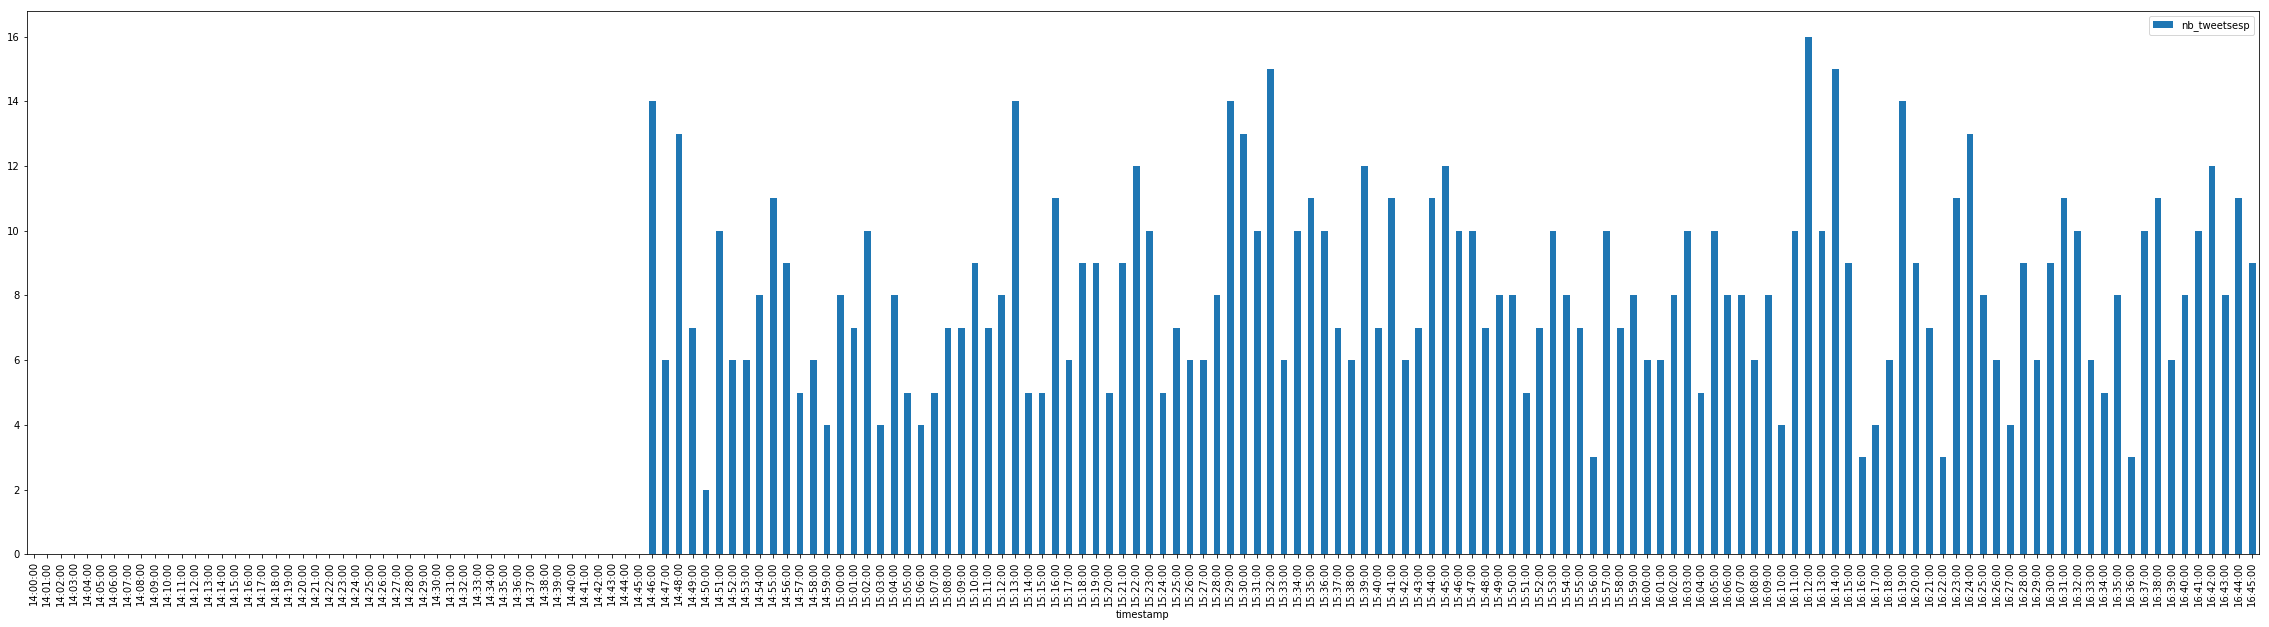

In [240]:
%matplotlib inline
df_espanaByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [241]:
df_ingl_esp=pd.concat([df_espanaByMinutes_filtered, df_inglaterraByMinutes_filtered['nb_tweetsingl']], axis=1)

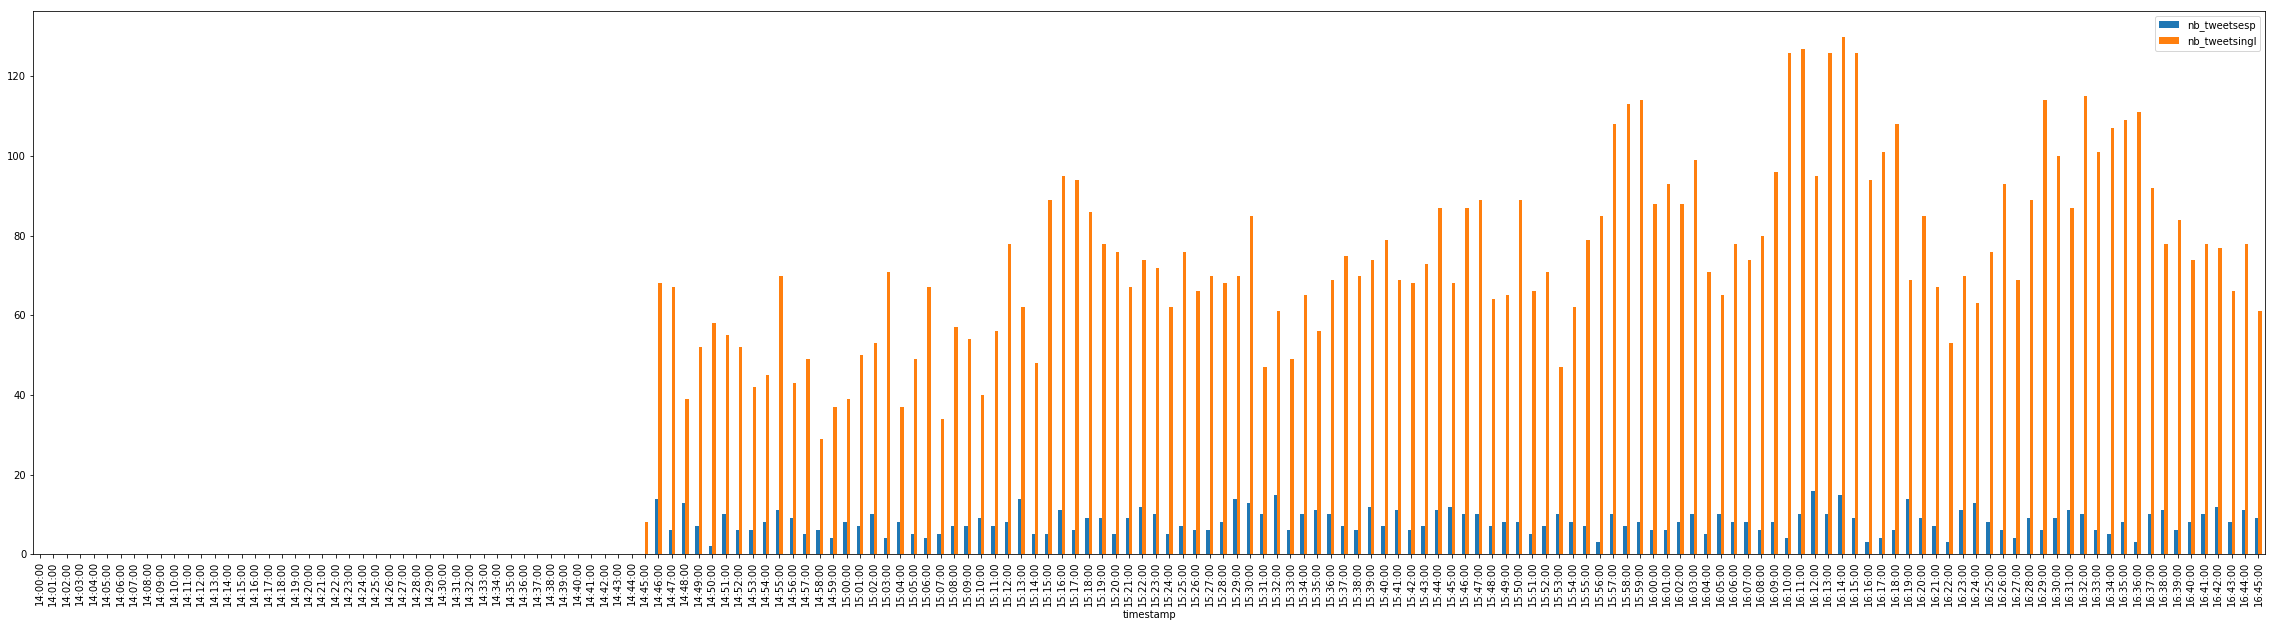

In [242]:
%matplotlib inline

df_ingl_esp.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

### 5. ¿Cómo podríamos analizar las emociones expresadas durante el partido? Proponer una metodología para responder a esta pregunta. (No es obligatorio implementar su metodología pero debe ser factible con las tecnologías que conocen). 

Primero haria un query para filtrar los tweets que tienen un emogy con cara feliz en el campo texto y los guardaria en un df de felicidad y haria lo mismo para los tweets que tengan cara de enojo o tristeza, los guardaria en otro df.